# Sentiment analysis on the IMDB Movie Reviews Dataset utilizing the NLTK technique, Naive bayes, Logistic regression, Decision tree, and Metrics such as Roc_curve and AUC value, Confusion_matrix, and Classification_report.

In [2]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [3]:
df = pd.read_csv(r"C:\Users\rr2om\OneDrive\Desktop\NLP_project\IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
Score = df['sentiment']
summary = df['review']
X_train, X_test, y_train, y_test = train_test_split(summary, Score, test_size = 0.2)

In [8]:
tmp = y_train
tmp.head()

49567    positive
27286    negative
22127    positive
11818    positive
37030    positive
Name: sentiment, dtype: object

In [9]:
##defining function for converting words to root words using porter stammer:
stemmer = PorterStemmer()
def stem_tokens(token, stemmer):
    stemmed=[]
    for i in token:
        stemmed.append(stemmer.stem(i))
    return stemmed

In [10]:
##defining function to tokenize sentance:
def tokenize(text):
    token = nltk.word_tokenize(text)
    stems = stem_tokens(token, stemmer)
    return ' '.join(stems)

In [11]:
##string punctuation:
intab = string.punctuation
outtab = len(intab)*' '
trantab = str.maketrans(intab, outtab)

In [12]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

In [13]:
corpus=[]
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text = tokenize(text)
    corpus.append(text)


X_train_counts = count_vect.fit_transform(corpus)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts) ##TFIDF = Term freq. inverse document freq.

In [14]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rr2om\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
test_set = []
for text in X_test:
    text = text.lower()
    text = tokenize(text)
    test_set.append(text)
    
X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [16]:
df = pd.DataFrame({'Before': X_train, 'After': corpus})
df.head()

,Before,After
49567,I just got back from the GLBT Film Festival at...,i just got back from the glbt film festiv at t...
27286,"As a Genghis Khan ""fan"" I was looking forward ...",as a genghi khan fan i wa look forward to thi ...
22127,"The movie, which was directed by Alfred Hitchc...",the movi which wa direct by alfr hitchcock wa ...
11818,At first i didn't like they way the director w...,at first i didn t like they way the director w...
37030,I saw Riverdance - The New Show and loved it f...,i saw riverd the new show and love it from the...


In [17]:
predictors = {}
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
predictors['Multinomial'] = model.predict(X_test_tfidf)

In [18]:
print(predictors)

{'Multinomial': array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'negative'], dtype='<U8')}


In [19]:
from sklearn.naive_bayes import BernoulliNB
model=BernoulliNB().fit(X_train_tfidf, y_train)
predictors['Bernoulli']= model.predict(X_test_tfidf)

In [20]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(C=1e6)
lr.fit(X_train_tfidf, y_train)
predictors['Logistic'] = lr.predict(X_test_tfidf)

C:\Users\rr2om\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
print(predictors)

{'Multinomial': array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'negative'], dtype='<U8'), 'Bernoulli': array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'negative'], dtype='<U8'), 'Logistic': array(['positive', 'positive', 'positive', ..., 'positive', 'negative',
       'positive'], dtype=object)}


In [22]:
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier()
dc.fit(X_train_tfidf, y_train)
predictors['DecisionTree'] = dc.predict(X_test_tfidf)

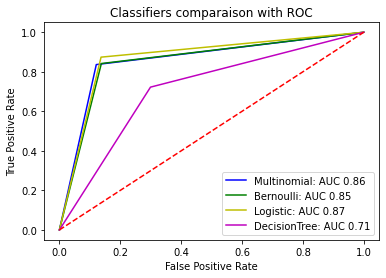

In [23]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y','m', 'k']
for model, predicted in predictors.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
print(classification_report(y_test, predictors['Logistic']))

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      4919
    positive       0.87      0.87      0.87      5081

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, predictors['Logistic']).ravel()

<AxesSubplot:>

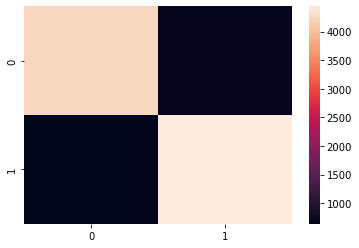

In [28]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, predictors['Logistic']))

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictors['Logistic'])

0.8687